In [17]:
# ============================================================
#  环境配置
#  - Colab 用户：取消注释下方 Colab 区块，注释掉 Local 区块
#  - 本地 Jupyter 用户：直接运行 Local 区块
# ============================================================

# ── Colab 环境（取消注释后运行） ──
!pip install torch torchvision matplotlib numpy -U -q

# ── 本地 Jupyter 环境 ──
# import subprocess, sys
# def _install(pkg):
#     subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

# _install("torch==2.10.0")
# _install("torchvision==0.25.0")
# _install("matplotlib==3.9.4")
# _install("numpy==1.26.4")

In [18]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# AlexNet 从零到一：源代码实现 vs 简洁实现

基于论文 *ImageNet Classification with Deep Convolutional Neural Networks* (Krizhevsky et al., 2012)，
用 **图像分类** 任务演示 AlexNet 的核心架构。

本 Notebook 包含两种实现，使用 **相同的超参数和数据**：

| | 实现 A — 源代码实现 | 实现 B — 简洁实现 |
|---|---|---|
| 核心思路 | 逐层手写 Conv/Pool/FC，含尺寸推导 | 调用 `torchvision.models.alexnet` |
| 代码量 | ~60 行 | ~15 行 |
| 适合场景 | 深入理解卷积网络、面试准备 | 快速原型、工程落地 |
| Dropout | 手动控制 `train()/eval()` 切换 | 内置于 `nn.Sequential` |

## 1. 数据准备

使用 **FashionMNIST** 数据集（10 类服饰图片，28×28 灰度）。
将图像 resize 到 224×224 以匹配 AlexNet 原始输入尺寸，并取 5000 条子集加速 CPU 训练。

| 属性 | 值 |
|------|-----|
| 原始尺寸 | 28×28×1 (灰度) |
| Resize 后 | 224×224×1 |
| 类别数 | 10 |
| 训练子集 | 5000 |
| 测试子集 | 1000 |

In [19]:
transform = transforms.Compose([
    transforms.Resize(224),               # 28×28 → 224×224
    transforms.ToTensor(),                 # [0,255] → [0,1] float32, shape (1, 224, 224)
    transforms.Normalize((0.5,), (0.5,))  # 归一化到 [-1, 1]
])

full_train = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform)
full_test = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform)

# 取子集，加速 CPU 训练
NUM_TRAIN, NUM_TEST = 5000, 1000
train_dataset = Subset(full_train, range(NUM_TRAIN))
test_dataset = Subset(full_test, range(NUM_TEST))

class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(f'训练集: {len(train_dataset)}, 测试集: {len(test_dataset)}')

训练集: 5000, 测试集: 1000


batch shape: torch.Size([128, 1, 224, 224]), labels: torch.Size([128])


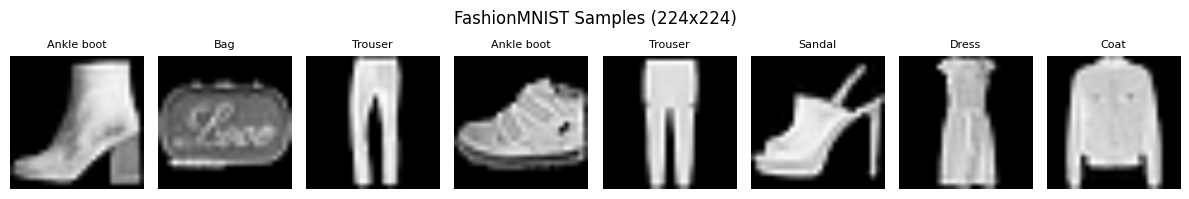

In [20]:
BATCH_SIZE = 128
train_iter = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, drop_last=True)
test_iter = DataLoader(test_dataset, BATCH_SIZE, shuffle=False)

# 验证 batch 形状
images, labels = next(iter(train_iter))
print(f'batch shape: {images.shape}, labels: {labels.shape}')  # (128, 1, 224, 224), (128,)

# 可视化前 8 张样本
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    img = images[i].squeeze().numpy() * 0.5 + 0.5  # 反归一化
    ax.imshow(img, cmap='gray')
    ax.set_title(class_names[labels[i]], fontsize=8)
    ax.axis('off')
plt.suptitle('FashionMNIST Samples (224x224)')
plt.tight_layout(); plt.show()

## 2. 共享组件

超参数、训练循环、评估函数——两种实现共用。

In [21]:
# ── 超参数（两种实现共用，集中管理） ──
IN_CHANNELS = 1      # FashionMNIST 灰度图（原版 AlexNet 为 3）
NUM_CLASSES = 10      # FashionMNIST 10 类（原版为 1000）
DROPOUT     = 0.5     # 论文值
LR          = 0.01    # 论文初始学习率
MOMENTUM    = 0.9     # 论文动量值
WEIGHT_DECAY = 5e-4   # 论文权重衰减 0.0005
NUM_EPOCHS  = 5       # CPU 友好（论文训练 90 epochs on GPU）

In [22]:
def train_model(net, train_iter, test_iter, num_epochs, lr, momentum, weight_decay, device):
    """通用训练函数，两种实现共用。使用论文中的 SGD + Momentum 优化器。"""
    net.to(device)
    optimizer = torch.optim.SGD(
        net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    train_losses, test_accs = [], []

    for epoch in range(num_epochs):
        net.train()  # 开启 Dropout
        total_loss, total_samples = 0.0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)                              # (batch, num_classes)
            loss = loss_fn(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * y.numel()
            total_samples += y.numel()

        avg_loss = total_loss / total_samples
        train_losses.append(avg_loss)

        # 每个 epoch 结束后评估
        acc = evaluate(net, test_iter, device)
        test_accs.append(acc)
        print(f'Epoch {epoch+1:2d}/{num_epochs}, '
              f'Loss: {avg_loss:.4f}, Test Acc: {acc:.2%}')

    return train_losses, test_accs


def evaluate(net, data_iter, device):
    """计算分类准确率。"""
    net.eval()  # 关闭 Dropout
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            preds = net(X).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.numel()
    return correct / total


def plot_results(losses, accs, title=''):
    """绘制 Loss 曲线和 Accuracy 曲线。"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(losses); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax2.plot(accs); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
    ax2.set_title('Test Accuracy')
    if title: fig.suptitle(title, fontsize=12)
    plt.tight_layout(); plt.show()

---
# 3. 实现 A — 源代码实现（From Scratch）

逐层手写 AlexNet 的 5 个卷积层 + 3 个全连接层，完整对应论文架构。

> **数据流**：输入图像 → 5 层卷积（特征提取） → 自适应平均池化 → 展平 → 3 层全连接（分类） → 输出 logits

### 3.1 卷积层与输出尺寸推导

**卷积输出尺寸公式**：给定输入尺寸 $H_{in}$，卷积核大小 $k$，步长 $s$，填充 $p$：

$$H_{out} = \left\lfloor \frac{H_{in} + 2p - k}{s} \right\rfloor + 1$$

**AlexNet 特征提取器逐层尺寸变化**（输入 $1 \times 224 \times 224$）：

| 层 | 操作 | 参数 | 输出尺寸 | 推导 |
|---|---|---|---|---|
| Conv1 | Conv2d | k=11, s=4, p=2 | 64×55×55 | $\lfloor(224+4-11)/4\rfloor+1 = 55$ |
| Pool1 | MaxPool2d | k=3, s=2 | 64×27×27 | $\lfloor(55-3)/2\rfloor+1 = 27$ |
| Conv2 | Conv2d | k=5, s=1, p=2 | 192×27×27 | $\lfloor(27+4-5)/1\rfloor+1 = 27$ |
| Pool2 | MaxPool2d | k=3, s=2 | 192×13×13 | $\lfloor(27-3)/2\rfloor+1 = 13$ |
| Conv3 | Conv2d | k=3, s=1, p=1 | 384×13×13 | $\lfloor(13+2-3)/1\rfloor+1 = 13$ |
| Conv4 | Conv2d | k=3, s=1, p=1 | 256×13×13 | $\lfloor(13+2-3)/1\rfloor+1 = 13$ |
| Conv5 | Conv2d | k=3, s=1, p=1 | 256×13×13 | $\lfloor(13+2-3)/1\rfloor+1 = 13$ |
| Pool5 | MaxPool2d | k=3, s=2 | 256×6×6 | $\lfloor(13-3)/2\rfloor+1 = 6$ |

**重叠池化**：Pool 的 kernel=3、stride=2，相邻池化窗口有 1 像素重叠（传统池化 kernel=stride 无重叠）。论文报告这将 top-1 错误率降低了 0.4%。

### 3.2 ReLU 激活函数

$$f(x) = \max(0, x)$$

ReLU 相比 Sigmoid/Tanh 的优势：正区间梯度恒为 1，不会出现梯度饱和，训练速度提升约 6 倍。

### 3.3 Dropout（训练 vs 推理的区别）

| 阶段 | 行为 | 代码触发方式 |
|------|------|------------|
| **训练** | 以概率 $p=0.5$ 随机将神经元输出置零，剩余值放大 $1/(1-p)$ 倍（保持期望不变） | `net.train()` |
| **推理** | 所有神经元正常工作，不进行丢弃 | `net.eval()` |

Dropout 在训练函数中通过 `net.train()` 开启，在 `evaluate()` 中通过 `net.eval()` 关闭。


In [23]:
class AlexNetScratch(nn.Module):
    """AlexNet 源代码实现：逐层手写，对应论文原始架构。"""
    def __init__(self, in_channels=IN_CHANNELS, num_classes=NUM_CLASSES, dropout=DROPOUT):
        super().__init__()
        # ===== 特征提取器：5 个卷积层 =====
        # Conv1: (batch, 1, 224, 224) → (batch, 64, 55, 55)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=11, stride=4, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)  # → (batch, 64, 27, 27)

        # Conv2: (batch, 64, 27, 27) → (batch, 192, 27, 27)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)  # → (batch, 192, 13, 13)

        # Conv3: (batch, 192, 13, 13) → (batch, 384, 13, 13)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)

        # Conv4: (batch, 384, 13, 13) → (batch, 256, 13, 13)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)

        # Conv5: (batch, 256, 13, 13) → (batch, 256, 13, 13)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)  # → (batch, 256, 6, 6)

        # 自适应池化，保证任意输入尺寸都能输出 6×6
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        # ===== 分类器：3 个全连接层 =====
        self.dropout = nn.Dropout(p=dropout)
        # FC1: 256*6*6=9216 → 4096
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        # FC2: 4096 → 4096
        self.fc2 = nn.Linear(4096, 4096)
        # FC3: 4096 → num_classes
        self.fc3 = nn.Linear(4096, num_classes)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # ── 特征提取 ──
        x = self.relu(self.conv1(x))   # (batch, 64, 55, 55)
        x = self.pool1(x)              # (batch, 64, 27, 27)
        x = self.relu(self.conv2(x))   # (batch, 192, 27, 27)
        x = self.pool2(x)              # (batch, 192, 13, 13)
        x = self.relu(self.conv3(x))   # (batch, 384, 13, 13)
        x = self.relu(self.conv4(x))   # (batch, 256, 13, 13)
        x = self.relu(self.conv5(x))   # (batch, 256, 13, 13)
        x = self.pool5(x)              # (batch, 256, 6, 6)
        x = self.avgpool(x)            # (batch, 256, 6, 6)

        # ── 分类器 ──
        x = torch.flatten(x, 1)        # (batch, 9216)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))     # (batch, 4096)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))     # (batch, 4096)
        x = self.fc3(x)                # (batch, num_classes)
        return x

In [24]:
# 验证模型结构与输出形状
net_a = AlexNetScratch()
dummy = torch.randn(2, IN_CHANNELS, 224, 224)
out = net_a(dummy)
print(f'输入: {dummy.shape} → 输出: {out.shape}')   # (2, 10)
total_params = sum(p.numel() for p in net_a.parameters())
print(f'总参数量: {total_params:,}')

输入: torch.Size([2, 1, 224, 224]) → 输出: torch.Size([2, 10])
总参数量: 57,029,322


### 3.4 训练实现 A

Training Implementation A — From Scratch
Epoch  1/5, Loss: 2.3018, Test Acc: 10.50%
Epoch  2/5, Loss: 2.2974, Test Acc: 10.50%
Epoch  3/5, Loss: 2.1728, Test Acc: 45.50%
Epoch  4/5, Loss: 1.5562, Test Acc: 51.60%
Epoch  5/5, Loss: 0.9960, Test Acc: 66.80%


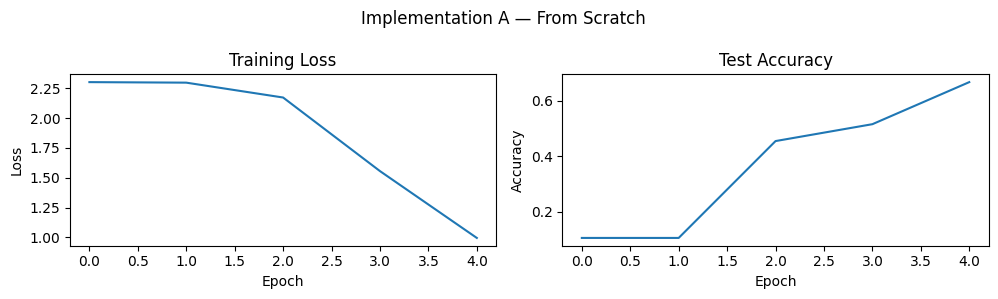

In [25]:
net_a = AlexNetScratch()
print('Training Implementation A — From Scratch')
losses_a, accs_a = train_model(
    net_a, train_iter, test_iter,
    NUM_EPOCHS, LR, MOMENTUM, WEIGHT_DECAY, device)
plot_results(losses_a, accs_a, 'Implementation A — From Scratch')

---
# 4. 实现 B — 简洁实现（Concise）

直接调用 `torchvision.models.alexnet`，修改输入通道和输出类别数即可。

| 源代码实现 | 简洁实现 (`torchvision.models`) |
|---|---|
| `AlexNetScratch.conv1~conv5` | `model.features` (内置 `nn.Sequential`) |
| `AlexNetScratch.avgpool` | `model.avgpool` |
| `AlexNetScratch.fc1~fc3 + dropout` | `model.classifier` (内置 `nn.Sequential`) |

**修改点**：
- `features[0]`：将第一层 `Conv2d(3, 64, ...)` 的 `in_channels` 从 3 改为 1（灰度图）
- `num_classes=10`：通过构造函数直接设置

In [26]:
from torchvision import models

net_b = models.alexnet(num_classes=NUM_CLASSES)
# 修改第一层卷积：3 通道 → 1 通道
net_b.features[0] = nn.Conv2d(IN_CHANNELS, 64, kernel_size=11, stride=4, padding=2)

print(net_b)
total_params_b = sum(p.numel() for p in net_b.parameters())
print(f'\n总参数量: {total_params_b:,}')

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### 4.1 训练实现 B

Training Implementation B — Concise
Epoch  1/5, Loss: 2.3021, Test Acc: 10.50%
Epoch  2/5, Loss: 2.3002, Test Acc: 10.50%
Epoch  3/5, Loss: 2.2953, Test Acc: 10.50%
Epoch  4/5, Loss: 2.1077, Test Acc: 45.90%
Epoch  5/5, Loss: 1.1775, Test Acc: 65.10%


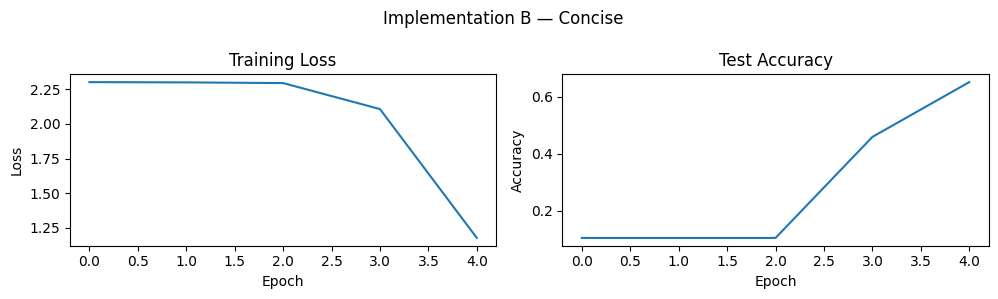

In [27]:
print('Training Implementation B — Concise')
losses_b, accs_b = train_model(
    net_b, train_iter, test_iter,
    NUM_EPOCHS, LR, MOMENTUM, WEIGHT_DECAY, device)
plot_results(losses_b, accs_b, 'Implementation B — Concise')

---
# 5. 结果对比

两种实现使用完全相同的超参数和数据，结果应当非常接近（随机初始化不同导致的微小差异）。

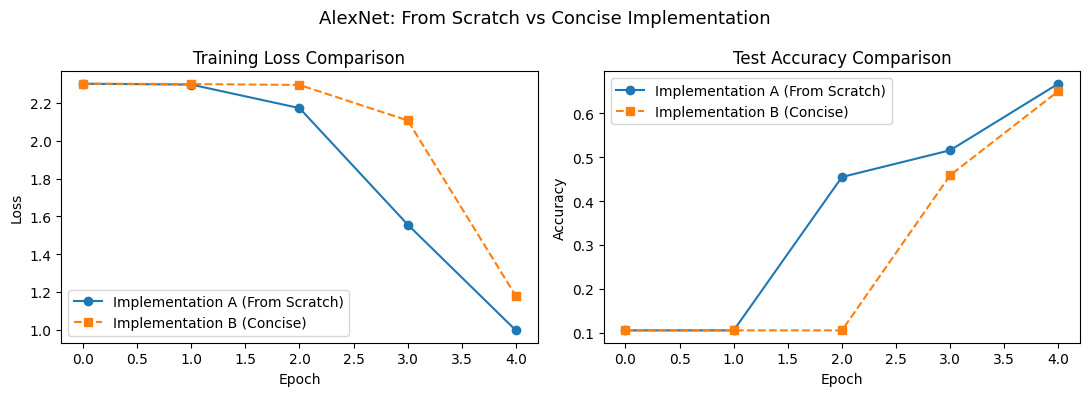

Implementation A Final Acc: 66.80%
Implementation B Final Acc: 65.10%


In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

ax1.plot(losses_a, 'o-', label='Implementation A (From Scratch)')
ax1.plot(losses_b, 's--', label='Implementation B (Concise)')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.set_title('Training Loss Comparison'); ax1.legend()

ax2.plot(accs_a, 'o-', label='Implementation A (From Scratch)')
ax2.plot(accs_b, 's--', label='Implementation B (Concise)')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy')
ax2.set_title('Test Accuracy Comparison'); ax2.legend()

plt.suptitle('AlexNet: From Scratch vs Concise Implementation', fontsize=13)
plt.tight_layout(); plt.show()

print(f'Implementation A Final Acc: {accs_a[-1]:.2%}')
print(f'Implementation B Final Acc: {accs_b[-1]:.2%}')

---
# 附录 A：卷积核可视化

查看 Conv1 学习到的 11×11 卷积核——这些是网络直接从图像像素中学习到的低级特征检测器（边缘、纹理等）。

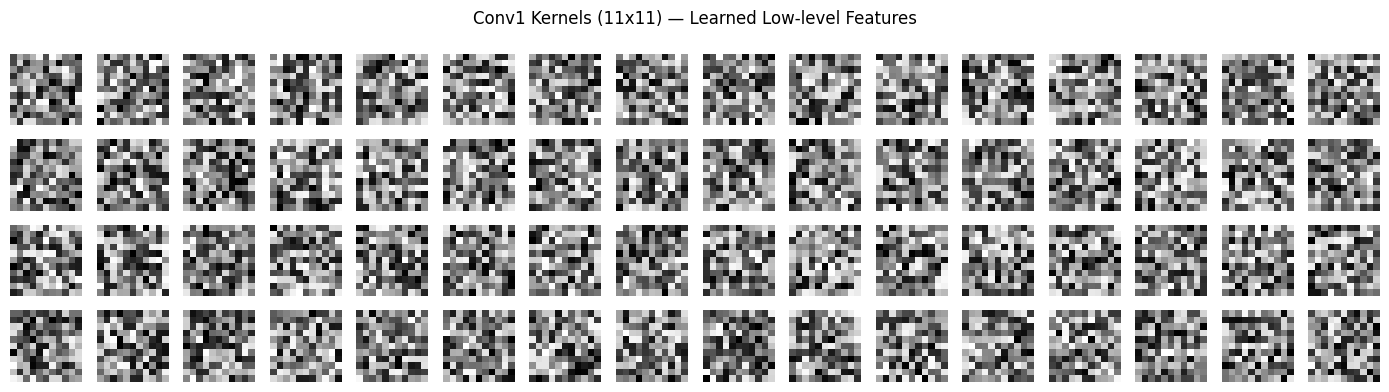

In [29]:
# 可视化 Conv1 的 64 个 11×11 卷积核
kernels = net_a.conv1.weight.data.cpu()  # (64, 1, 11, 11)
fig, axes = plt.subplots(4, 16, figsize=(14, 4))
for i, ax in enumerate(axes.flat):
    if i < kernels.shape[0]:
        ax.imshow(kernels[i, 0], cmap='gray')
    ax.axis('off')
plt.suptitle('Conv1 Kernels (11x11) — Learned Low-level Features', fontsize=12)
plt.tight_layout(); plt.show()

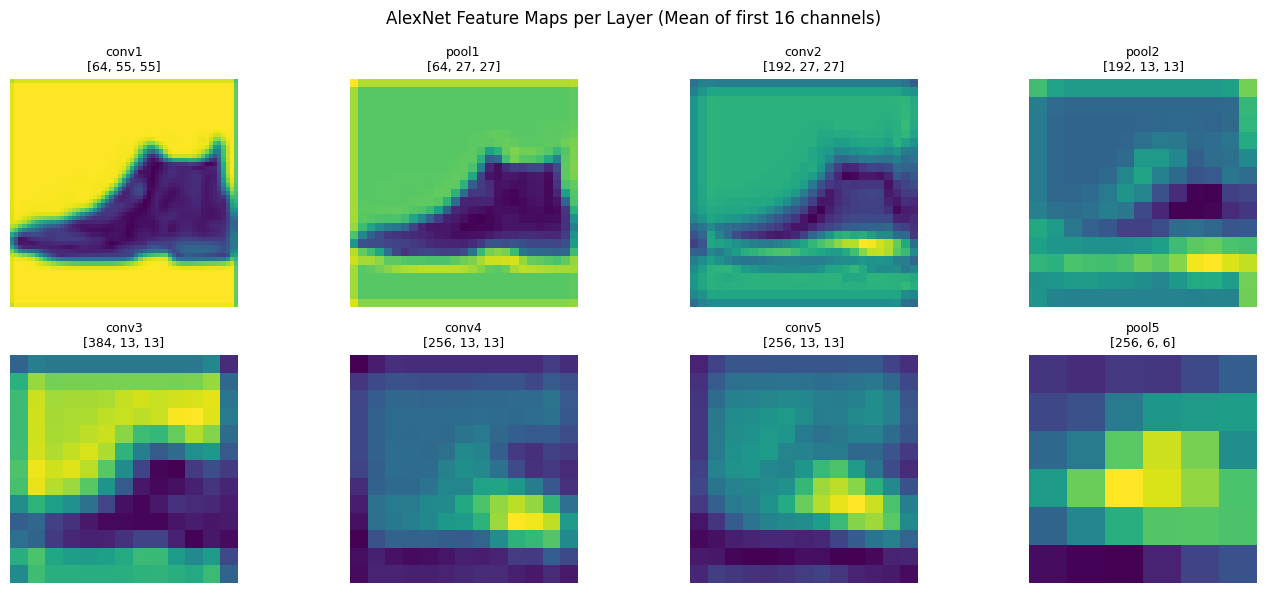

In [30]:
# 可视化各层特征图（取测试集第一张图）
sample_img = test_dataset[0][0].unsqueeze(0).to(device)  # (1, 1, 224, 224)
net_a.eval()

feature_maps = []
x = sample_img
with torch.no_grad():
    for name in ['conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'conv4', 'conv5', 'pool5']:
        layer = getattr(net_a, name)
        x = layer(x)
        if 'conv' in name:
            x = net_a.relu(x)
        feature_maps.append((name, x.cpu()))

fig, axes = plt.subplots(2, 4, figsize=(14, 6))
for idx, (name, fmap) in enumerate(feature_maps):
    ax = axes[idx // 4, idx % 4]
    ax.imshow(fmap[0, :16].mean(dim=0), cmap='viridis')
    ax.set_title(f'{name}\n{list(fmap.shape[1:])}', fontsize=9)
    ax.axis('off')
plt.suptitle('AlexNet Feature Maps per Layer (Mean of first 16 channels)', fontsize=12)
plt.tight_layout(); plt.show()

---
# 附录 B：面试拓展

## 高频面试题

**Q1: AlexNet 的网络结构是怎样的？**

8 个可学习层：5 个卷积层 + 3 个全连接层。
- Conv1 (11×11, stride=4, 96 filters) → ReLU → MaxPool → Conv2 (5×5, 256) → ReLU → MaxPool → Conv3-5 (3×3) → MaxPool → FC6 (9216→4096) → FC7 (4096→4096) → FC8 (4096→1000)
- 总参数量约 6100 万，绝大部分集中在全连接层

---

**Q2: AlexNet 有哪些关键创新点？**

1. **ReLU**：替代 sigmoid/tanh，解决梯度消失，训练速度提升 ~6 倍
2. **Dropout**（p=0.5）：全连接层随机丢弃神经元，抑制过拟合
3. **数据增强**：翻转、裁剪、颜色抖动
4. **双 GPU 并行**：模型拆分到两块 GPU，突破显存限制
5. **重叠池化**：kernel=3, stride=2，窗口重叠 1 像素，降低 0.3% top-5 错误率
6. **LRN（局部响应归一化）**：模拟侧抑制，降低 1.2% top-5 错误率

---

**Q3: 为什么用 ReLU 而不是 Sigmoid？**

- **计算效率**：ReLU 只需 `max(0, x)`，无指数运算
- **梯度消失**：Sigmoid 在饱和区梯度趋近 0，深层网络反传困难；ReLU 正区间梯度恒为 1
- **稀疏激活**：部分神经元输出为 0，产生稀疏表示，有正则化效果

---

**Q4: Dropout 为什么能防止过拟合？**

训练时以概率 p=0.5 随机置零神经元输出，推理时使用全部神经元。机制：
- 减少神经元间的**共适应性**，迫使每个神经元学习更鲁棒的特征
- 隐式训练了指数级子网络的集成（ensemble）
- 在线性模型上等价于 **L2 正则化**

---

**Q5: LRN 是什么？为什么现代网络不再使用？**

LRN 对同一空间位置上相邻通道做归一化，模拟生物神经系统的"侧抑制"。
**被弃用的原因**：Batch Normalization（2015）在整个 mini-batch 上做归一化，效果全面优于 LRN，且能加速训练、稳定梯度。

---

**Q6: 重叠池化有什么作用？**

传统池化 kernel=stride（如 2×2, stride=2），无重叠。AlexNet 用 kernel=3, stride=2，相邻区域有 1 像素重叠。
- 保留更多空间信息
- 实验降低约 0.3% top-5 错误率
- 使模型更不容易过拟合

---

**Q7: AlexNet 的 4096 维向量有什么用？**

FC7 输出的 4096 维向量是图片的**语义特征压缩表示**（feature embedding）：
- 可作为迁移学习的特征提取器：去掉最后分类层，用 4096 维向量输入下游任务
- "CNN 特征 + SVM 分类器"的范式在 AlexNet 之后被广泛使用

---

**Q8: AlexNet 与 VGG 的主要区别是什么？**

| 对比项 | AlexNet | VGG-16 |
|--------|---------|--------|
| 层数 | 8（5 conv + 3 fc） | 16（13 conv + 3 fc） |
| 卷积核 | 大核混用（11×11, 5×5, 3×3） | 统一 3×3 |
| 参数量 | ~6100 万 | ~1.38 亿 |
| 核心思想 | 大核 + 多创新技巧 | 深度（小核堆叠等效大感受野） |

VGG 的关键洞察：两个 3×3 感受野 = 一个 5×5，三个 3×3 = 一个 11×11，但参数更少、非线性更强。

---

**Q9: AlexNet 的历史意义？**

2012 年 ILSVRC 竞赛 top-5 错误率 **15.3%**，大幅领先第二名（26.2%），差距超 10 个百分点。证明了：
- 深度 CNN 可自动学习层次化特征，超越手工特征（SIFT/SURF）
- 大数据 + GPU 算力是深度学习成功的关键
- 开启了"深度学习革命"

---

**Q10: 如何用 AlexNet 做迁移学习？**

1. 加载预训练权重：`models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)`
2. 冻结特征层：`for p in model.features.parameters(): p.requires_grad = False`
3. 替换分类头：`model.classifier[6] = nn.Linear(4096, num_target_classes)`
4. 只训练分类头（或用小学习率微调全网络）

---

## 延伸阅读与对比

| 对比维度 | AlexNet (2012) | VGG (2014) | ResNet (2015) |
|---------|----------------|------------|---------------|
| 核心思想 | 深度 CNN + ReLU + Dropout | 更深 + 统一小核 | 残差连接跨层捷径 |
| 深度 | 8 层 | 16/19 层 | 50/101/152 层 |
| 参数量 | 61M | 138M | 25M (ResNet-50) |
| Top-5 错误率 | 15.3% | 7.3% | 3.57% |
| 关键贡献 | 证明深度学习可行 | 证明深度有效 | 解决退化问题 |

## 进阶探索方向

- **Network-in-Network (NiN)**：用 1×1 卷积替代全连接层，大幅减少参数量
- **GoogLeNet / Inception**：多尺度并行卷积（Inception module），兼顾效率与表达力
- **轻量化网络**：MobileNet、ShuffleNet 等，在移动端部署 CNN